# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [3]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import warnings
warnings.filterwarnings(action='ignore')

# MNIST

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

In [9]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [10]:
28*28

784

`fetch_mldata`는 0.22 버전에서 삭제될 예정입니다. 0.20 버전에서 관련된 경고를 피하기 위해 대신 `fetch_openml` 함수를 사용하는 것이 좋습니다.

Saving figure some_digit


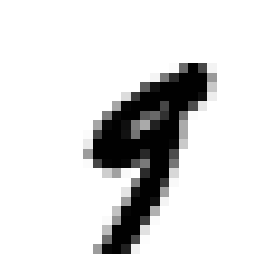

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit")
plt.show()

In [13]:
y[36000]

9

In [18]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [19]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


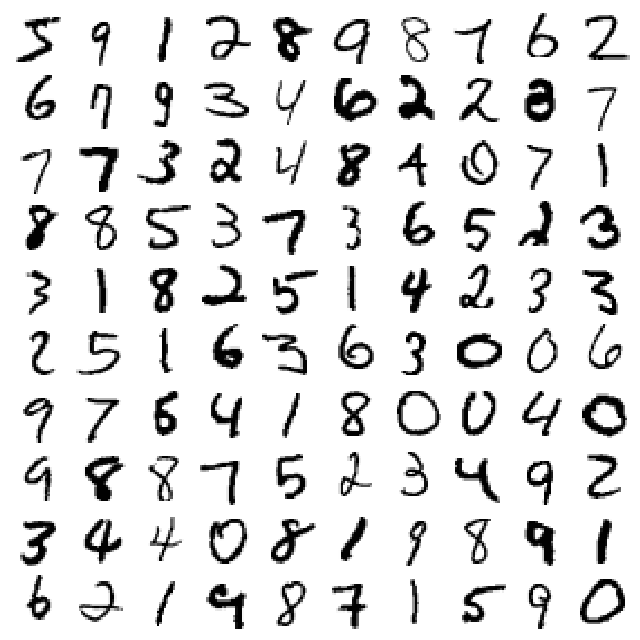

In [20]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [22]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 이진 분류기

In [23]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [25]:
sgd_clf.predict([some_digit])

array([False])

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.964 , 0.9579, 0.9571])

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.964
0.9579
0.9571


In [28]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

In [33]:
y_train_perfect_predictions = y_train_5

In [34]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [35]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8711352955725946

In [36]:
4432 / (4432 + 1607)

0.7338963404537175

In [37]:
recall_score(y_train_5, y_train_pred)

0.6496956281128943

In [38]:
4432 / (4432 + 989)

0.8175613355469471

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7442941673710904

In [40]:
4432 / (4432 + (1607 + 989)/2)

0.7734729493891798

In [41]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-400042.39513131])

In [42]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [43]:
y_some_digit_pred

array([False])

In [44]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [45]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

노트: 만약 사이킷런 0.19.0 버전을 사용하고 있다면 `method="decision_function"` 옵션으로 `cross_val_predict()` 함수를 사용할 때 이진 분류에서 1차원 배열이 아니고 2차원 배열을 반환하는 [버그](https://github.com/scikit-learn/scikit-learn/issues/9589)가 있습니다. 사이킷런 0.19.1로 업그레이드하거나 다음 셀에서 y_scores\[:, 1\] 처럼 두 번째 열만 사용해야 합니다.

In [46]:
y_scores.shape

(60000,)

In [47]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
# if y_scores.ndim == 2:
#     y_scores = y_scores[:, 1]

In [48]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

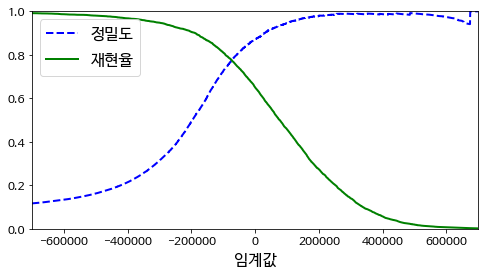

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

plt.show()

In [50]:
(y_train_pred == (y_scores > 0)).all()

True

In [51]:
y_train_pred_90 = (y_scores > 70000)

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.9309882747068676

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.5126360450101457

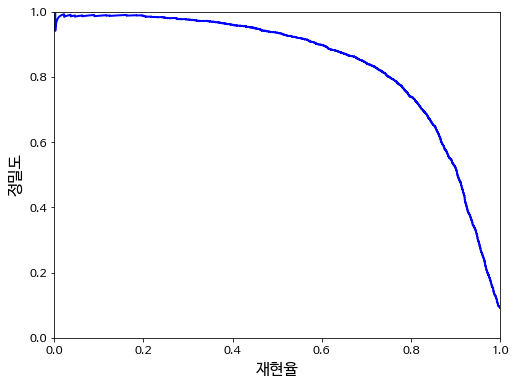

In [54]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC 곡선

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

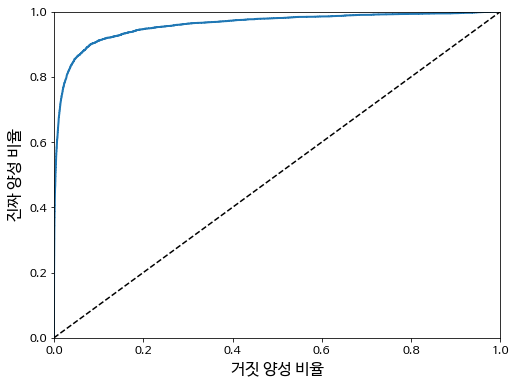

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율', fontsize=16)
    plt.ylabel('진짜 양성 비율', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [57]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9598058535696421

랜덤 포레스트 `n_estimator` 매개변수의 기본값이 0.22 버전에서 10에서 100으로 변경될 예정입니다. 경고를 피하기 위해서 `n_estimator=10`으로 지정합니다.

In [58]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [59]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양성 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

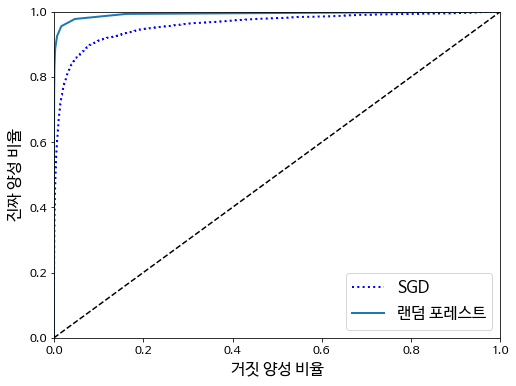

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [61]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928250745111685

In [62]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9870386643233744

In [63]:
recall_score(y_train_5, y_train_pred_forest)

0.8288138719793396

# 다중 분류

In [64]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9])

In [65]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-780634.17445014, -367988.10902669, -857510.2219226 ,
        -109587.17435534,   -6978.239532  , -120352.38122307,
        -785831.32198027, -377771.38059503, -198143.6559996 ,
         107815.22648992]])

In [66]:
np.argmax(some_digit_scores)

9

In [67]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [68]:
sgd_clf.classes_[4]

4

In [69]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4])

In [70]:
len(ovo_clf.estimators_)

45

In [71]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9])

In [72]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87217556, 0.87109355, 0.83892584])

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91106779, 0.9080454 , 0.90888633])

In [75]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5741,    2,   22,   11,   11,   40,   48,    7,   39,    2],
       [   2, 6457,   49,   28,    6,   45,    9,   11,  125,   10],
       [  55,   35, 5323,   98,   79,   24,  104,   62,  162,   16],
       [  47,   40,  140, 5314,    3,  254,   34,   57,  141,  101],
       [  19,   25,   41,    9, 5360,   10,   56,   36,   77,  209],
       [  76,   39,   30,  174,   76, 4610,  110,   29,  168,  109],
       [  36,   20,   42,    2,   39,   89, 5632,    7,   50,    1],
       [  23,   19,   61,   26,   54,   11,    7, 5826,   14,  224],
       [  56,  149,   78,  143,   12,  163,   56,   27, 5012,  155],
       [  46,   30,   26,   83,  160,   35,    3,  207,   74, 5285]],
      dtype=int64)

In [76]:
def plot_confusion_matrix(matrix):
    """컬러 오차 행렬을 원할 경우"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

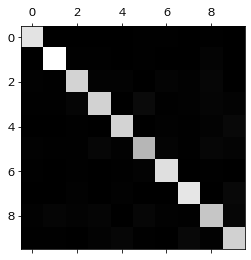

In [77]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [78]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

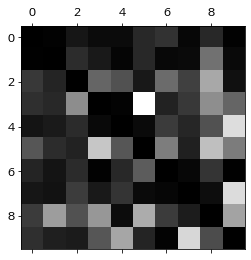

In [79]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

plt.show()

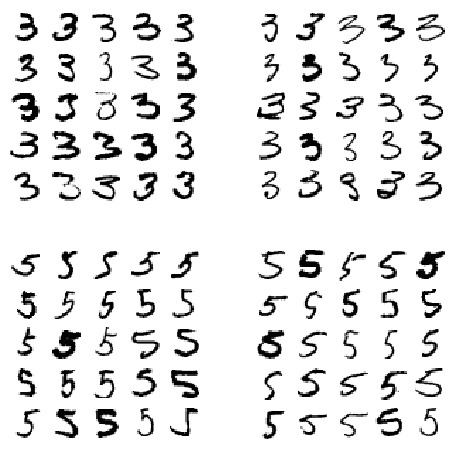

In [80]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

# 다중 레이블 분류

In [81]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [82]:
knn_clf.predict([some_digit])

array([[ True,  True]])

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

In [83]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9768224011622285

# 다중 출력 분류

In [84]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

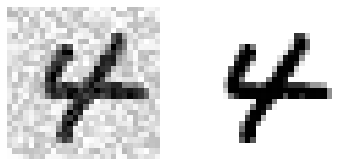

In [85]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

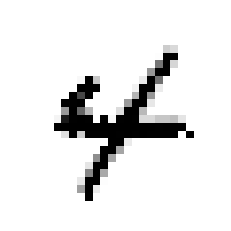

In [86]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

plt.show()

# 추가 내용

## 더미 (즉, 랜덤) 분류기

In [87]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

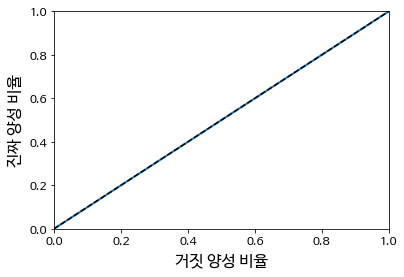

In [88]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN 분류기

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [90]:
y_knn_pred = knn_clf.predict(X_test)

In [91]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

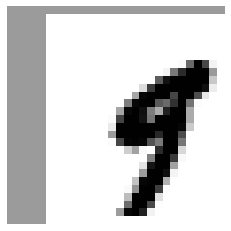

In [92]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [93]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [94]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [95]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [96]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [97]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

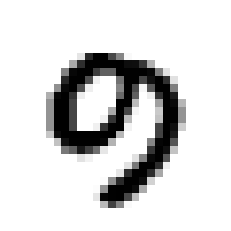

In [98]:
plot_digit(ambiguous_digit)